In [26]:
#Split and scale the data, train hyper parameters, Model, Evaluate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import cross_validation, metrics  
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import pandas as pd
from sklearn import datasets, linear_model
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


%store -r df

print(df.info())
print(df.shape)


   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 999
Data columns (total 10 columns):
search_word                  989 non-null object
contentDetails.caption       989 non-null bool
contentDetails.definition    989 non-null object
catID                        989 non-null int64
commentCount                 989 non-null float64
dislikeCount                 989 non-null float64
likeCount                    989 non-null float64
tags_length                  989 non-null int64
view_bucket                  989 non-null float64
date                         989 non-null datetime64[ns, UTC]
dtypes: bool(1), datetime64[ns, UTC](1), float64(4), int64(2), object(2)
memory usage: 118.2+ KB
None
(989, 10)


In [2]:
minmax_scale = preprocessing.MinMaxScaler().fit(df[['commentCount','dislikeCount','likeCount','tags_length']])




X = pd.DataFrame(minmax_scale.transform(df[['commentCount','dislikeCount','likeCount','tags_length']]))
print(X.shape)
Y = df['view_bucket']

n = pd.get_dummies(df[['search_word','contentDetails.definition','contentDetails.caption']])

# X = pd.concat([X, n], axis=1)
print(X.shape)





(989, 4)
(989, 4)


In [3]:
#X = pd.concat([X, n], axis=1)
X = pd.DataFrame(np.hstack([X,n]))
X.shape



(989, 27)

In [4]:
# Normalize the time series data and store as new date column
ts = df['date']
scaled_ts = (ts-ts.min())/(ts.max()-ts.min())

X['date'] = pd.Series(scaled_ts)
X['date'].fillna((X['date'].mean()), inplace=True)

print(X.shape)


(989, 28)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.9, random_state=0)

X_train.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 304 to 684
Data columns (total 28 columns):
0       890 non-null object
1       890 non-null object
2       890 non-null object
3       890 non-null object
4       890 non-null object
5       890 non-null object
6       890 non-null object
7       890 non-null object
8       890 non-null object
9       890 non-null object
10      890 non-null object
11      890 non-null object
12      890 non-null object
13      890 non-null object
14      890 non-null object
15      890 non-null object
16      890 non-null object
17      890 non-null object
18      890 non-null object
19      890 non-null object
20      890 non-null object
21      890 non-null object
22      890 non-null object
23      890 non-null object
24      890 non-null object
25      890 non-null object
26      890 non-null object
date    890 non-null float64
dtypes: float64(1), object(27)
memory usage: 201.6+ KB


C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:


model = sm.OLS(list(y_train), X_train.astype(float)).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     86.24
Date:                Wed, 19 Dec 2018   Prob (F-statistic):          2.39e-219
Time:                        13:35:28   Log-Likelihood:                -6135.3
No. Observations:                 890   AIC:                         1.232e+04
Df Residuals:                     863   BIC:                         1.245e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0          -1761.9512    300.543     -5.863      0.0

In [7]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
print('Linear Regression R squared: %.4f' % regressor.score(X_test, y_test))

lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)



Linear Regression R squared: 0.7756
Linear Regression RMSE: 322.1439
Linear Regression MAE: 116.9394


In [8]:
# Try random forest with default hyperparameters
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [9]:
print('Random Forest R squared: %.4f' % forest_reg.score(X_test, y_test))
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest R squared: 0.3879
Random Forest RMSE: 532.0794


In [10]:
# Evaluate and select optimal hyperparameters
print(forest_reg.get_params())

#Create a random grid for possible parameters to attempt and then use random search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [12]:
#Print and evaluate best parameters from the search
print(rf_random.best_params_)

best_random = rf_random.best_estimator_

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [13]:
#Evaluate performance of the base model w/ searched hyperparameters

base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
predictions = base_model.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))



Model Performance
Average Error: 151.8758 degrees.
Accuracy = 19.58%.


In [14]:
predictions = best_random.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))


Model Performance
Average Error: 88.1599 degrees.
Accuracy = -13.91%.


In [15]:
# Try Grid Search to see if we can improve the hyperparameters further. 
# Setting grid around the previously identified optimal values
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60, 70],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [100, 200, 300, 1000]
}


In [16]:
# Create a based model
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [17]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.9min finished


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [18]:
best_grid = grid_search.best_estimator_
predictions = best_grid.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
Average Error: 108.5852 degrees.
Accuracy = -162.67%.


In [19]:
# Try Gradient Boosting
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [20]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting R squared": 0.0651
Gradient Boosting RMSE: 657.5881


In [22]:
#Basic GBM Regressor performance was poor - try tuning learning rate and number of trees

p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,200,300,400,500]}

tuning = GridSearchCV(estimator =GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3,n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.74355, std: 0.09953, params: {'learning_rate': 0.15, 'n_estimators': 100},
  mean: 0.74335, std: 0.10029, params: {'learning_rate': 0.15, 'n_estimators': 200},
  mean: 0.74366, std: 0.10062, params: {'learning_rate': 0.15, 'n_estimators': 300},
  mean: 0.74369, std: 0.10066, params: {'learning_rate': 0.15, 'n_estimators': 400},
  mean: 0.74364, std: 0.10067, params: {'learning_rate': 0.15, 'n_estimators': 500},
  mean: 0.74133, std: 0.09621, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.73960, std: 0.09697, params: {'learning_rate': 0.1, 'n_estimators': 200},
  mean: 0.74055, std: 0.09789, params: {'learning_rate': 0.1, 'n_estimators': 300},
  mean: 0.74062, std: 0.09781, params: {'learning_rate': 0.1, 'n_estimators': 400},
  mean: 0.74074, std: 0.09788, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: 0.74759, std: 0.10437, params: {'learning_rate': 0.05, 'n_estimators': 100},
  mean: 0.75242, std: 0.10806, params: {'learning_rate': 0.05, 'n_esti

In [23]:
#Tune max_depth utilizing learning_rate of .05 and n_estimators of 300

p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingRegressor(learning_rate=0.05,n_estimators=300, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2,n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.71886, std: 0.10170, params: {'max_depth': 2},
  mean: 0.75168, std: 0.10093, params: {'max_depth': 3},
  mean: 0.75319, std: 0.10891, params: {'max_depth': 4},
  mean: 0.73977, std: 0.12580, params: {'max_depth': 5},
  mean: 0.74374, std: 0.10745, params: {'max_depth': 6},
  mean: 0.75210, std: 0.10823, params: {'max_depth': 7}],
 {'max_depth': 4},
 0.7531939159875336)

In [24]:
model1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)

Accuracy of the GBM on test set: 0.374
             precision    recall  f1-score   support

        1.0       0.64      0.91      0.75        33
        2.0       0.38      0.30      0.33        10
        3.0       0.25      0.50      0.33         4
        4.0       0.00      0.00      0.00         2
        5.0       0.00      0.00      0.00         1
        6.0       1.00      0.33      0.50         3
        7.0       0.00      0.00      0.00         0
        8.0       0.00      0.00      0.00         1
        9.0       1.00      0.50      0.67         2
       10.0       0.00      0.00      0.00         0
       11.0       0.00      0.00      0.00         0
       13.0       0.00      0.00      0.00         1
       14.0       0.00      0.00      0.00         1
       15.0       0.00      0.00      0.00         0
       16.0       0.00      0.00      0.00         2
       17.0       0.00      0.00      0.00         2
       18.0       0.00      0.00      0.00         0
      

C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\z002xczx\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


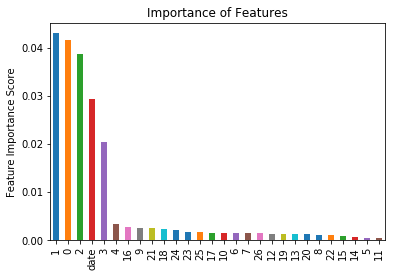

In [27]:
predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
#Try tree related parameters

p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,max_depth=4, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test4,n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_